<a href="https://colab.research.google.com/github/jasreman8/LLMs-For-RAGs/blob/main/Health_Insurance_Policy_Assistant_using_RAG_%26_ChromaDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Using LLMs for Retrieval-Augmented Generation

## Business Context

### Implementing a RAG System for Health Insurance Policy Q&A

**Problem Scenario:**

In today's unpredictable world, where healthcare costs continue to rise, having comprehensive health insurance is essential.

However, health insurance policy documents are often lengthy, complex, and difficult to understand.

As a result, many policyholders fail to fully read or comprehend their coverage details, discovering too late that certain treatments, diseases, or situations are excluded.

This lack of understanding can lead to claim denials and financial strain.

# Objective

To address these challenges, we propose implementing a **Retrieval-Augmented Generation (RAG) system** designed to simplify insurance policy comprehension.

This system will enable users to ask natural language questions, thereby improving the accessibility and understanding of health insurance policies.

By clarifying coverage upfront, customers can avoid surprises during claims, leading to increased satisfaction and retention.

The RAG application will simplify interactions with policy documents, allowing individuals to query specific aspects of their health insurance coverage and receive clear, concise explanations.

This will help customers better understand their policies before purchasing, ensuring they make informed decisions about their health coverage.

# Installing and Importing the Necessary Libraries

In this section, we install and import libraries required to run the notebook:

- The `openai` package provides the official OpenAI API client for accessing models like GPT-4, Whisper, DALL·E, including its embedding models

- The `tiktoken`	library provides access to OpenAI's tokenizer models, crucial for chunking and token counting

- The `pypdf` library parses and extracts text from PDF files — useful for document ingestion

- LangChain is a GenAI framework to build applications with LLMs using chains and agents.
  - `langchain` is the core library that provides access to various LangChain abstractions
  - `langchain-community` provides access to 3rd-party integrations (e.g., different vector stores, tools)
  - `langchain-chroma` provides specific integration to use ChromaDB as the vector store backend in LangChain
  - `langchain-openai` module provides a plug-in interface for LangChain to call OpenAI's LLMs using standardized interface

- `chromadb` library provides access to ChromaDB vector database, which is a fast, vector database optimized for retrieval in RAG systems

# Installing the required libraries
!pip install -q openai==1.66.3 \
                tiktoken==0.9.0 \
                pypdf==5.4.0 \
                langchain \
                langchain-community \
                langchain-chroma \
                langchain-openai==0.3.9 \
                chromadb==0.6.3 \
                posthog==2.4.2 \
                numpy==2.0.0

**Importing the Libraries**

The following code imports the necessary modules and libraries to set up a Retrieval-Augmented Generation (RAG) system using OpenAI, LangChain, and ChromaDB

In [2]:
# Importing the standard Libraries
import time                           # For measuring execution time or adding delays
from datetime import datetime         # For handling timestamps and datetime operations

# ChromaDB Vector Database
import chromadb  # Chroma: a local-first vector database for storing and querying document embeddings

# OpenAI SDK
from openai import OpenAI # Official OpenAI Python SDK (v1.x) for interacting with models like GPT-4

# LangChain Utilities
# RecursiveCharacterTextSplitter intelligently breaks long text into smaller chunks with some overlap, preserving context.
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Loads all PDF files from a directory and extracts text from each.
from langchain_community.document_loaders import PyPDFDirectoryLoader

# Base class representing a document in LangChain; useful for downstream chaining and processing.
from langchain_core.documents import Document

# Embeddings and Vector Store
# Generates vector embeddings using OpenAI’s embedding models (e.g., `text-embedding-3-small`)
from langchain_openai import OpenAIEmbeddings

# Integration for using Chroma as the vector store within LangChain’s ecosystem
from langchain_chroma import Chroma

In [3]:
# Hide warnings/logs from Chroma
# This code mutes the following telemetry error in ChromaDB:
# ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
import logging
logging.getLogger("chromadb").setLevel(logging.CRITICAL)

In [4]:
# Accessing environment variables via Colab Secrets
from google.colab import userdata

# Set the OpenAI key in Colab Secrets
openai_api_key = userdata.get('my_api_key') # Replace with the appropriate secret key name

# Refer to the content page present at the top of module for accessing the Open AI API_KEY from Olympus platform
# The following code sets up the OpenAI client instance with the API Key and the API Endpoint
client = OpenAI(
    api_key = openai_api_key,
)

# GPT-4o-mini will be the primary model used in this notebook
model_name = 'gpt-4o-mini'

# Review of CRUD Operations in ChromaDB

CRUD stands for **Create**, **Read**, **Update**, and **Delete** — the four basic operations for managing data in any persistent storage system (like databases). In the context of vector databases, CRUD does the following:

* **CREATE**: Inserting vectors (embeddings) and their metadata
* **READ**: Searching and retrieving vectors, typically through similarity searches or by ID lookup
* **UPDATE**: Modifying existing vectors or their metadata and reindexing vectors
* **DELETE**: Removing vectors and their metadata from the index

Together, these CRUD operations bring traditional database behaviors to vector database systems, which foundational to how data is handled in GenAI applications, ensuring full lifecycle management of information.

This notebook will focus on **ChromaDB**, a vector database optimized for working with embeddings, which are essentially the vector representations of text.

CRUD operations in ChromaDB work similarly to traditional databases but are tailored to handle vector-based data used in applications like Retrieval-Augmented Generation (RAG) pipelines.

In the following codes, we will look at the various CRUD operations on ChromaDB

Together, these operations can be used to implement a RAG Q&A pipeline.

## **CREATE**

We will create a persistent Chroma vector database and populate this database with several records created from Max Bupa Health Pulse
Policy Document.

Each record will contain the text chunks from these documents in its vector format using an embedding model, and its metadata (e.g., source, page number).

In [5]:
# Unzip the dataset containing the policy document
!unzip policy_dataset.zip

Archive:  policy_dataset.zip
   creating: policy_datasets/
  inflating: policy_datasets/maxbupa-health-pulse-t-and-c.pdf  
  inflating: __MACOSX/policy_datasets/._maxbupa-health-pulse-t-and-c.pdf  


The following code loads the pdf document from the given folder location, chunks the documents.

In [6]:
# Set the directory where PDF files are stored
pdf_folder_location = "policy_datasets"

# Initialize a PDF loader to load all PDF documents in the directory
pdf_loader = PyPDFDirectoryLoader(pdf_folder_location)

# Initialize a text splitter based on token counts using OpenAI’s tokenizer ('cl100k_base')
# - chunk_size: maximum size of each chunk (in tokens)
# - chunk_overlap: number of overlapping tokens between chunks to preserve context
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',  # OpenAI tokenizer for accurate token count
    chunk_size=512,               # Limit each chunk to 512 tokens
    chunk_overlap=16              # Keep 16-token overlap between consecutive chunks
)

# Load the PDF documents and split them into chunks using the text splitter
maxbupa_chunks = pdf_loader.load_and_split(text_splitter)

The chunks are stored in a `list` data structure

In [7]:
# Data type of the chunks
type(maxbupa_chunks)

list

In [8]:
# length of the resulting chunks
len(maxbupa_chunks)

105

The chunks are stored within LangChain's [Document class](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) which contains the `metadata` and the `page_content` attributes.

In [9]:
# Chunks are stored within LangChain's Document class
maxbupa_chunks[0]

Document(metadata={'producer': 'macOS Version 15.3.2 (Build 24D81) Quartz PDFContext, AppendMode 1.1', 'creator': 'CorelDRAW 2020', 'creationdate': "D:20210930060224Z00'00'", 'author': 'Vaseem Khan', 'moddate': "D:20250404032304Z00'00'", 'title': '04.cdr', 'source': 'policy_datasets/maxbupa-health-pulse-t-and-c.pdf', 'total_pages': 48, 'page': 0, 'page_label': '1'}, page_content="1. Preamble\n This 'Max Bupa Health Pulse' policy is a contract of insurance between You and Us which is subject to payment of full \npremium in advance and the terms, conditions and exclusions of this Policy. This Policy has been issued on the basis of the \nDisclosure to Information Norm, including the information provided by You in the Proposal Form and the Information \nSummary Sheet.\n Please inform Us immediately of any change in the address or any other changes aﬀecting You or any Insured Person which \nwould impact the beneﬁts, terms and conditions under this Policy.\n In addition, please note the list

In [10]:
# The individual text chunks can be accessed via the `.page_content` attribute of the `Document` class
# Inspecting the contents of the first page by accessing its .page_content attribute
maxbupa_chunks[0].page_content

# The metadata corresponding to the first chunk can be accessed via the .metadata attribute
maxbupa_chunks[0].metadata

{'producer': 'macOS Version 15.3.2 (Build 24D81) Quartz PDFContext, AppendMode 1.1',
 'creator': 'CorelDRAW 2020',
 'creationdate': "D:20210930060224Z00'00'",
 'author': 'Vaseem Khan',
 'moddate': "D:20250404032304Z00'00'",
 'title': '04.cdr',
 'source': 'policy_datasets/maxbupa-health-pulse-t-and-c.pdf',
 'total_pages': 48,
 'page': 0,
 'page_label': '1'}

In [11]:
# Let's define the ChromaDB collection name to store the chunks
maxbupa_collection = 'maxbupa-health-pulse'

This following code sets up the OpenAI embedding model `text-embedding-3-small` and initializes a persistent ChromaDB client to store and retrieve document embeddings in a local directory.

In [12]:
# Instantiate the OpenAI embedding model
embedding_model = OpenAIEmbeddings(
    api_key = openai_api_key, # OpenAI API key
    model = 'text-embedding-3-small' # OpenAI's lightweight and cost-effective embedding model
)

We first instantiate a Chroma client to interact and store the vector embeddings.

Chroma provides two ways to initialize a client:
* `chromadb.Client()` - an in-memory client (everything is lost when the script ends/ runtime is restarted)
* `chromadb.PersistentClient()` - a persistent client that saves data to disk
The PersistentClient() class creates a client that stores all vector collections, embeddings, and metadata on disk. It uses SQLite databases as the storage backend by default and ensures that the data survives even after the Python process exits or the system reboots.




In [13]:
# Initialize a persistent Chroma client
# The following code persists the data in the local disk

chromadb_client = chromadb.PersistentClient(
    path="./maxbupa_db", # Local directory where vector database will be stored
 )

In [14]:
# Pinging the database client to check if the connection is alive
# the heartbeat method returns the current time in nanoseconds and is generally used to check if the server is alive
chromadb_client.heartbeat()

1768439762210422292

In [15]:
# Confirming database is empty
chromadb_client.count_collections()

0

Creating a vectorstore collection for the Chroma collection `maxbupa_collection`.

Chroma collections store your embeddings, documents, and any additional metadata. Collections index the embeddings and documents, and enable efficient retrieval and filtering.

In [16]:
# Instantiate a Chroma vector store to store and retrieve document embeddings
vectorstore = Chroma(
    collection_name = maxbupa_collection,               # Name of the Chroma collection to group related embeddings
    collection_metadata = {"hnsw:space": "cosine"},     # Use cosine similarity for nearest-neighbor search (HNSW index)
    embedding_function = embedding_model,               # Embedding model used to convert text into vectors
    client = chromadb_client,                           # Persistent Chroma client initialized earlier
    persist_directory = "./maxbupa_db"                  # Directory where Chroma will persist its data
)

In [17]:
# confirming collection creation
chromadb_client.list_collections()

['maxbupa-health-pulse']

In [18]:
# Confirming database has been populated with the collection
chromadb_client.count_collections()

1

Let's add documents to the created *maxbupa-health-pulse* collection in the vector store in batches.

The following code uses the `.add_documents` method to add the chunks to the database in batches of 500 for efficient processing.

In [19]:
# Batch 500 chunks to send to the API at a time, pausing execution for 30 seconds afterward
i = 0 # Initialize the starting index for the chunks

while i < len(maxbupa_chunks): # Iterate while the index is less than the total number of chunks
    vectorstore.add_documents( # Add documents to the vector store in batches of 500
        documents=maxbupa_chunks[i:i+500], # Get the current batch of 500 chunks
        ids=["text_" + str(i) for i in range(i, i+500)] # Assign unique IDs to each chunk in the batch
    )

    i += 500 # Move to the next batch by incremening the index by 500
    time.sleep(30) # Pause for 30 seconds to avoid rate limiting issues with the vector store

## **READ**

Once the database is created, the stored entries can be retrieved by initializing a new Chroma instance (denoted as **vectorstore_persisted** to distinguish between creation and read operations) and directing it to the persistent storage directory containing the document embeddings.

In [20]:
vectorstore_persisted = Chroma(
    collection_name = maxbupa_collection,
    collection_metadata = {"hnsw:space": "cosine"},
    embedding_function = embedding_model,
    client = chromadb_client,
    persist_directory = "./maxbupa_db"
)

There are two valuable types of READ operations in vector databases:

1. **Inspecting individual records**
2. **Retrieving relevant records based on a user query**

Let us look at each in turn.

**Inspecting individual records**

The following code retrieves an existing collection `maxbupa_collection` (analogous to a table in relational databases) from the ChromaDB instance

In [21]:
# Define the chroma collection
collection = chromadb_client.get_collection(maxbupa_collection)

In [22]:
# Count the number of records in the collection
collection.count()

105

In [23]:
# Inspect the first 2 records using the .peek() method
collection.peek(1)

{'ids': ['text_0'],
 'embeddings': array([[0.0212335 , 0.01391041, 0.03345396, ..., 0.01980796, 0.01923315,
         0.0209001 ]]),
 'documents': ["1. Preamble\n This 'Max Bupa Health Pulse' policy is a contract of insurance between You and Us which is subject to payment of full \npremium in advance and the terms, conditions and exclusions of this Policy. This Policy has been issued on the basis of the \nDisclosure to Information Norm, including the information provided by You in the Proposal Form and the Information \nSummary Sheet.\n Please inform Us immediately of any change in the address or any other changes aﬀecting You or any Insured Person which \nwould impact the beneﬁts, terms and conditions under this Policy.\n In addition, please note the list of exclusions is set out in Section 6 of this Policy.\n2. Deﬁnitions \n For the purposes of interpretation and understanding of this Policy, We have deﬁned some of the important words used in \nthe Policy which will have the special m

In [24]:
# Inspect a specific record in the collection
collection.get(
    ids = ['text_99']
)

{'ids': ['text_99'],
 'embeddings': None,
 'documents': ["Procedure Name Procedure NameSr. No. Procedure Name Sr. No. Sr. No.\n396 ORIF with plating- small long \nbones\nImplant removal minor\nK wire removal\nPOP application\nClosed reduction and external \nfixation\nArthrotomy hip joint\nSyme's amputation\nArthroplasty\nPartial removal of RIB\nTreatment of sesamoid bone \nfracture\nShoulder arthroscopy / surgery\nElbow arthroscopy\nAmputation of metacarpal bone\nRelease of thumb contracture\nIncision of foot fascia\nCalcaneum SPUR hydrocort \ninjection\nGanglion wrist hyalase \ninjection\nPartial removal of metatarsal\nRepair / graft of foot tendon\nRevision/removal of knee cap\nAmputation follow-up surgery\nExploration of ankle joint\nRemove/graft leg bone lesion\nRepair/graft achilles tendon\nRemove of tissue expander\nBiopsy elbow joint lining\nRemoval of wrist prosthesis\nBiopsy finger joint lining\nTendon lengthening\nTreatment of shoulder dislocation\nLengthening of hand tendon\

**Retrieving relevant records based on a user query**

The primary function of the vector database is to retrieve relevant records based on user queries and to facilitate this process, we implement a retriever that utilizes the query embeddings to query the database.

The following code uses HNSW algorithm to calculate the nearest neighbors for the user query and returns the corresponding documents from the database.

In [25]:
# Create a retriever interface from the vector store
retriever = vectorstore_persisted.as_retriever(
    search_type = 'similarity',             # Use the default method based on semantic similarity
    search_kwargs = {'k': 5}                # Retrieve top 5 most similar chunks
)

# Define a sample user query
user_query = "Malignancy cases coverage"

The following code performs the similarity search based on the user query by using the `.invoke()` method.

In [26]:
# Perform similarity search to returns top 5 document chunks based on sample user query
retriever.invoke(user_query)

[Document(id='text_1', metadata={'author': 'Vaseem Khan', 'creationdate': "D:20210930060224Z00'00'", 'creator': 'CorelDRAW 2020', 'moddate': "D:20250404032304Z00'00'", 'page': 0, 'page_label': '1', 'producer': 'macOS Version 15.3.2 (Build 24D81) Quartz PDFContext, AppendMode 1.1', 'source': 'policy_datasets/maxbupa-health-pulse-t-and-c.pdf', 'title': '04.cdr', 'total_pages': 48}, page_content="Indian Medicine/Central Council of Homeopathy; or\nc. AYUSH Hospital, standalone or co-located with In-patient healthcare facility of any recognized system of \nmedicine, registered with the local authorities, wherever applicable, and is under the supervision of a \nqualiﬁed registered AYUSH Medical Practitioner and must comply with all the following criterion: \ni. Having at least 5 in-patient beds\nii. Having qualiﬁed AYUSH Medical Practitioner in charge round the clock; \niii. Having dedicated AYUSH therapy sections as required and/or has equipped operation theatre where \nsurgical procedures 

## **UPDATE**

Updating any individual record on one or more fields associated with it.

The `update_document` method updates one document by ID.

In [27]:
# Define the chunk index that needs to be updated
record_index_for_update = 22

# Display the record for the given index
vectorstore_persisted.get(
    ids = [f'text_{record_index_for_update}']
)

{'ids': ['text_22'],
 'embeddings': None,
 'documents': ["3.13. Mental Disorders Treatment\nWhat is covered:\nWe will indemnify the expenses incurred by the Insured Person for Inpatient treatment for Mental Illness up to the \nlimit as speciﬁed in Your Policy Schedule.\nConditions - The above coverage is subject to fulﬁlment of following conditions: \na. Mental Disorders Treatment is only covered where patient is diagnosed by a qualiﬁed psychiatrist and / or referred \nto a clinical psychologist for further treatment. \nb. The Hospitalization is for Medically Necessary Treatment and prescribed in writing by a registered mental health \nspecialist, psychiatrist or clinical psychologist.\nc. The treatment should be taken in Hospitals having registration under the Clinical Establishments (Registration and \nRegulation) Act, 2010 and complies with the following minimum criteria:\n i. Has qualiﬁed psychiatric doctor who is registered with respective medical council;\n ii. Has dedicated ment

In [28]:
# The following code updates the record for the given index
# The code creates a new Document object containing the same page_content as the original chunk
# But inserts a new metadata
vectorstore_persisted.update_document(
    document_id = 'text_' + str(record_index_for_update),
    document = Document(
        page_content = maxbupa_chunks[record_index_for_update].page_content,
        metadata = {"creator": "johndoe"}
    )
)

# An additional entry has been added to the metadata field
vectorstore_persisted.get(
    ids = [f'text_{record_index_for_update}']
)

{'ids': ['text_22'],
 'embeddings': None,
 'documents': ["3.13. Mental Disorders Treatment\nWhat is covered:\nWe will indemnify the expenses incurred by the Insured Person for Inpatient treatment for Mental Illness up to the \nlimit as speciﬁed in Your Policy Schedule.\nConditions - The above coverage is subject to fulﬁlment of following conditions: \na. Mental Disorders Treatment is only covered where patient is diagnosed by a qualiﬁed psychiatrist and / or referred \nto a clinical psychologist for further treatment. \nb. The Hospitalization is for Medically Necessary Treatment and prescribed in writing by a registered mental health \nspecialist, psychiatrist or clinical psychologist.\nc. The treatment should be taken in Hospitals having registration under the Clinical Establishments (Registration and \nRegulation) Act, 2010 and complies with the following minimum criteria:\n i. Has qualiﬁed psychiatric doctor who is registered with respective medical council;\n ii. Has dedicated ment

In [29]:
# Perform a semantic search user the user_query
retriever.invoke(user_query[0])

[Document(id='text_92', metadata={'author': 'Vaseem Khan', 'creationdate': "D:20210930060224Z00'00'", 'creator': 'CorelDRAW 2020', 'moddate': "D:20250404032304Z00'00'", 'page': 43, 'page_label': '44', 'producer': 'macOS Version 15.3.2 (Build 24D81) Quartz PDFContext, AppendMode 1.1', 'source': 'policy_datasets/maxbupa-health-pulse-t-and-c.pdf', 'title': '04.cdr', 'total_pages': 48}, page_content='in ANO\n95\n96\n97\n98\n99\n100\n101\n102\n103\n104\n105\n106\n107\n108\n109\n110\n111\n112\n113\n114\n115\n116\n117\n118\n119\n120\n121\n122\n123\n124\n125\n126\n127\n128\n129\n130\n131\n132\n133\n134\n135\n136\n137\n138\n139\n140\n141\n142\n143\n144\n145\n146\n147\n148\n149\n150\n152\n153\n154\n155\n156\n157\n158\n159\n160\n161\n162\n163\n164\n165\n166\n167\n168\n169\n170\n171\n172\n173\n174\n175\n176\n177\n178\n179\n180\n181\n182\n183\n184\n185\n186\n187\n188\n189\n190\n191\n192\n193\n194\n195\n196\n197\n198\n199\nProduct Name: Max Bupa Health Pulse | Product UIN: MAXHLIP21174V022021'),
 Do

## **DELETE**

In [30]:
##  The following line deletes records and should be used with caution
# vectorstore.delete(ids=['text_99'])
# vectorstore_persisted.delete(ids=['text_99'])

# RAG Q&A System for Health Insurance Policy

In this caselet, we will create the end-to-end RAG pipeline for querying Health Insurance Policies using the CRUD operations defined above.

The RAG pipeline will follow the format illustrated in the diagram below.

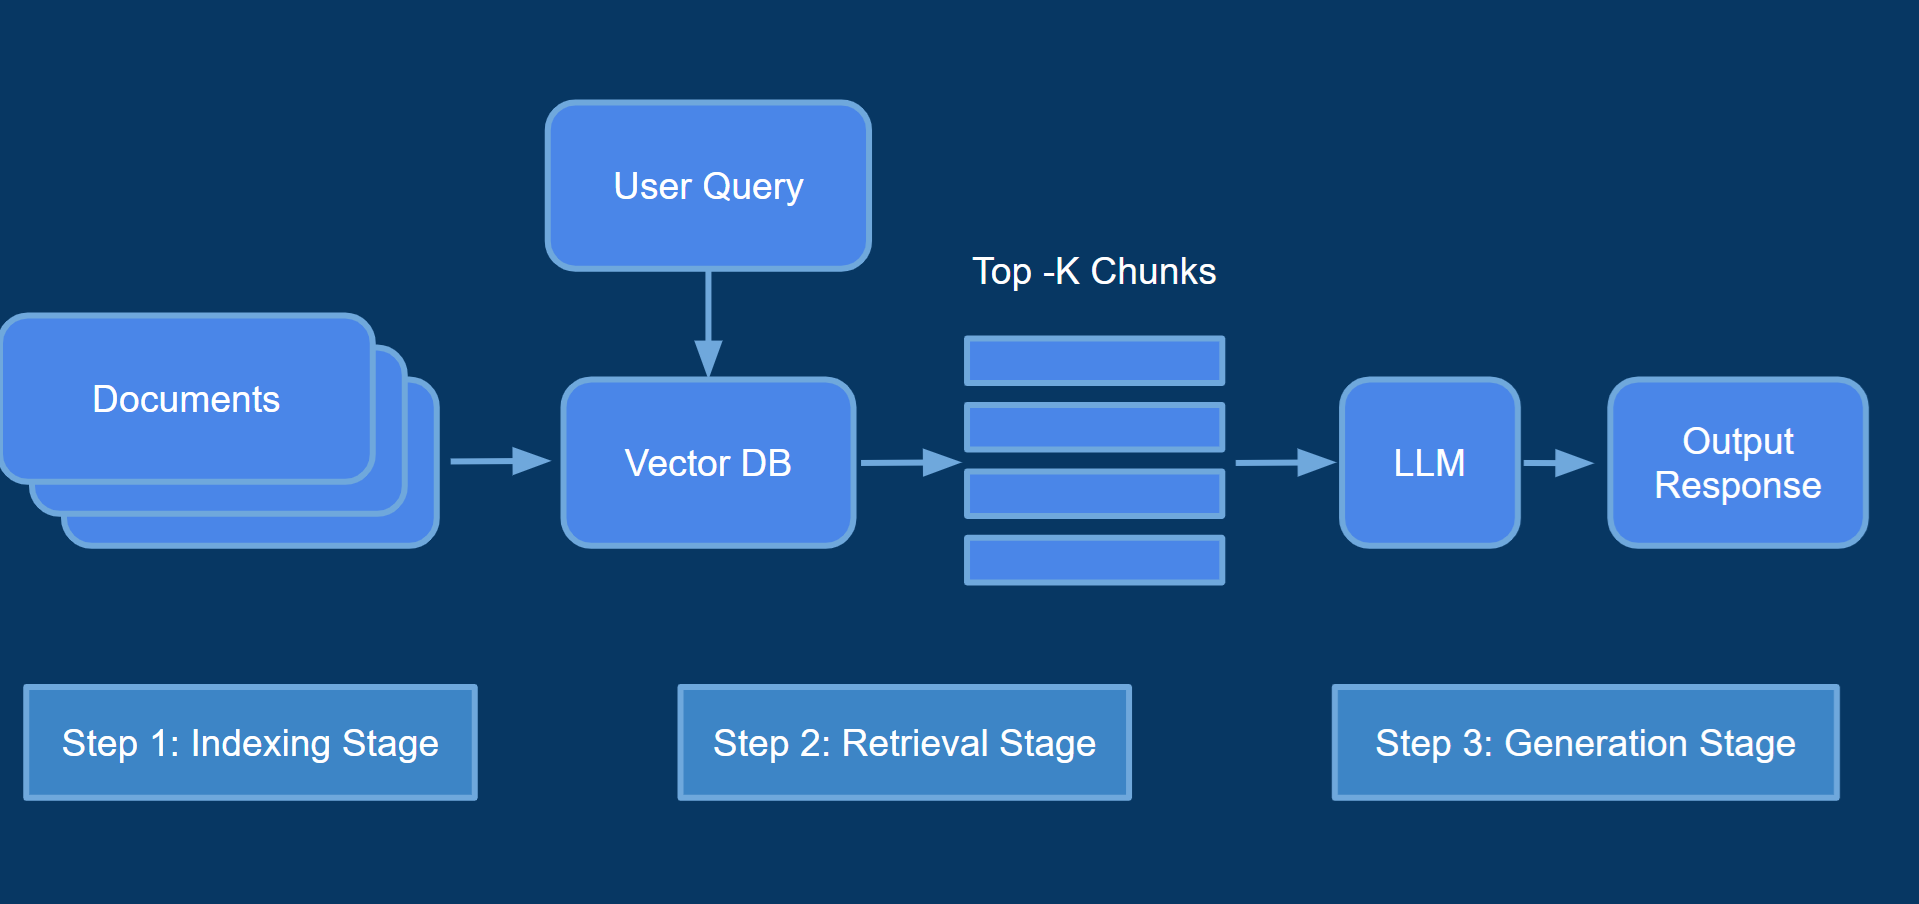

A typical RAG implementation consists of the following stages:
* Indexing Stage
* Retrieval Stage
* Generation Stage

| Stage          | Key Activities                                        | Role in RAG                              |
| -------------- | ----------------------------------------------------- | ---------------------------------------- |
| **Indexing**   | Chunking · Embedding · Storing                        | Prepares data for efficient retrieval    |
| **Retrieval**  | Query embedding · Similarity search   | Consolidates relevant context            |
| **Generation** | Prompt construction · LLM generation | Produces final response grounded in data |


Let's now put together the RAG pipeline using these stages.

**Note** that the **Indexing Stage** has already been performed in the previous sections.

## Retrieval Stage

**Retrieving Relevant Documents**

The following codes performs the Retrieval stage in the RAG pipeline.

Let's define a sample user query to test the RAG pipeline

In [31]:
user_query = "What exclusions apply specifically to mental health treatment coverage?"

Retrieve the relevant chunks from the documents based on the `user_query`.

Note we're accessing the `retriever` that has been defined already and we're not repeating the text processing pipeline performed earlier.

In [32]:
relevant_document_chunks = retriever.invoke(user_query)

In [33]:
len(relevant_document_chunks)

5

In [34]:
# Inspecting the first document
for document in relevant_document_chunks:
    print(document.page_content.replace("\t", " "))
    break

3.13. Mental Disorders Treatment
What is covered:
We will indemnify the expenses incurred by the Insured Person for Inpatient treatment for Mental Illness up to the 
limit as speciﬁed in Your Policy Schedule.
Conditions - The above coverage is subject to fulﬁlment of following conditions: 
a. Mental Disorders Treatment is only covered where patient is diagnosed by a qualiﬁed psychiatrist and / or referred 
to a clinical psychologist for further treatment. 
b. The Hospitalization is for Medically Necessary Treatment and prescribed in writing by a registered mental health 
specialist, psychiatrist or clinical psychologist.
c. The treatment should be taken in Hospitals having registration under the Clinical Establishments (Registration and 
Regulation) Act, 2010 and complies with the following minimum criteria:
 i. Has qualiﬁed psychiatric doctor who is registered with respective medical council;
 ii. Has dedicated mental therapy sections;
 iii. Maintains daily records of patients.
d.   P

## Generation Stage

This section will perform the **Generation** stage of the RAG pipeline.

We will pass the relevant context chunks to the LLM, along with the system message and user message via a prompt template.

These are then passed to the LLM to compose an appropriate response to the user's query.


### Prompt Template

Defining the system message for the RAG chatbot with the appopriate role, context and the relevant instructions.

In [35]:
qna_system_message = """
You are an assistant to a health insurance firm who answers user queries on health insurance policies.
User input will have the context required by you to answer user queries.
This context will be delimited by:
<Context> and </Context>.
The context contains references to specific portions of a document relevant to the user query.
User queries will be delimited by:
<Question> and </Question>.
Please answer user queries only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.
If the answer is not found in the context, respond "I don't know".
"""

The following user message prompt template provides the relevant chunks and the user query within the `context` and `question` placeholders respectively.

In [36]:
qna_user_message_template = """
<Context>
Here are some documents that are relevant to the question mentioned below.
{context}
</Context>

<Question>
{question}
</Question>
"""

### Generating the Response

In [40]:
user_query = "What exclusions apply specifically to mental health treatment coverage?"

relevant_document_chunks = retriever.invoke(user_query)
context_list = [d.page_content for d in relevant_document_chunks]
context_for_query = "\n---\n".join(context_list)

prompt = [
    {'role': 'developer', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_query
        )
    }
]

try:
    response = client.chat.completions.create(
        model=model_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The exclusions that apply specifically to mental health treatment coverage are:

a. The condition which is not clinically significant or is related to anxiety, bereavement, relationship or academic problems, acculturation difficulties or work pressure.  
b. Treatment related to intentional self-inflicted injury or attempted suicide by any means.  
c. Treatment and complications related to disorders of intoxication, dependence, abuse, and withdrawal caused by drugs and other substances such as alcohol, opioids or nicotine.


# Putting it all together - Insurance RAG Q&A Chatbot

We'll now put together the relevant codes for the RAG pipeline into a file named `rag-chat.py` to create a basic command-line chat interface which can run via  the terminal.

This naive RAG implementation illustrates how document Q&A could be automated for any domain.

The following codes use the `%%writefile` magic command specific to Google Colab, which allows the content of a cell to be written directly into a file on the virtual machine's disk.

This allows for the creation of scripts, configuration files, or data files within the Colab environment. These files are available during the Colab runtime and are deleted when the runtime is stopped or deleted.

The `!python` shell command can be used to execute a Python script (.py files) or commands within the Colab environment.

In [38]:
%%writefile rag-chat.py
import os
import chromadb
import sys # Import sys to access command-line arguments

from openai import OpenAI

from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
import logging
logging.getLogger("chromadb").setLevel(logging.CRITICAL)

# Remove the import of google.colab.userdata as it's not available when running as a script
# from google.colab import userdata


model_name = 'gpt-4o-mini'
maxbupa_collection = 'maxbupa-health-pulse'

# Read the API key from command-line arguments
if len(sys.argv) > 1:
    openai_api_key = sys.argv[1]
else:
    # Fallback or error handling if API key is not provided as an argument
    print("Error: OpenAI API key not provided as a command-line argument.")
    sys.exit(1)


client = OpenAI(
    api_key=openai_api_key,
)

embedding_model = OpenAIEmbeddings(
    api_key=openai_api_key,
    model='text-embedding-3-small'
)

chromadb_client = chromadb.PersistentClient(
    path="./maxbupa_db"
)

vectorstore_persisted = Chroma(
    collection_name=maxbupa_collection,
    collection_metadata={"hnsw:space": "cosine"},
    embedding_function=embedding_model,
    client=chromadb_client,
    persist_directory="./maxbupa_db"
)

retriever = vectorstore_persisted.as_retriever(
    search_type='similarity',
    search_kwargs={'k': 5}
)

qna_system_message = """
You are an assistant to a health insurance firm who answers user queries on health insurance policies.
User input will have the context required by you to answer user queries.
This context will be delimited by:
<Context> and </Context>.
The context contains references to specific portions of a document relevant to the user query.
User queries will be delimited by:
<Question> and </Question>.
Please answer user queries only using the context provided in the input.
Do not mention anything about the context in your final answer. Your response should only contain the answer to the question.
If the answer is not found in the context, respond "I don't know".
"""

qna_user_message_template = """
<Context>
Here are some documents that are relevant to the question mentioned below.
{context}
</Context>

<Question>
{question}
</Question>
"""

def respond(user_query):
    relevant_document_chunks = retriever.invoke(user_query)
    context_list = [d.page_content for d in relevant_document_chunks]
    context_for_query = "\n---\n".join(context_list)

    prompt = [
        {'role': 'developer', 'content': qna_system_message},
        {
            'role': 'user', 'content': qna_user_message_template.format(
             context=context_for_query,
             question=user_query)
        }
    ]

    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=prompt,
            temperature=0
        )

        answer = response.choices[0].message.content.strip()
    except Exception as e:
        answer = f'Sorry, I encountered the following error: \n {e}'

    return answer

def main():
    """
    Runs the main interactive loop for the Q&A system.

    This function initializes the conversation history, continuously prompts
    the user for queries, processes the queries using the `respond` function,
    and displays the assistant's responses. It also maintains the
    conversation history for context.

    Args:
        None

    Returns:
        None
    """

    # 1. Initialize conversation history.
    # This list stores the conversation between the user and the assistant.
    # It starts with a system message introducing the assistant's role.
    conversation_history = [
        {'role': 'developer', 'content': 'You are a helpful assistant who answers user queries on health insurance policies'}

        ]

    # 2. Enter the interactive loop.
    # The loop continues until the user enters 'q' to quit.
    while True:
        # 2.1 Get user input.
        # Prompt the user to enter a query and store it in `user_query`.
        user_query = input("User (type q to quit): ")

        # 2.2 Check for quit condition.
        # If the user enters 'q', break out of the loop.
        if user_query == 'q':
            break

        # 2.3 Process the query and get the answer.
        # Call the `respond` function to process the user query and get the answer.
        answer = respond(user_query)

        # 2.4 Update conversation history.
        # Add the user's query and the assistant's answer to the conversation history.
        conversation_history.append({'role': 'user', 'content': user_query})
        conversation_history.append({'role': 'assistant', 'content': answer})

        # 2.5 Display the assistant's answer.
        # Print the assistant's answer to the console.
        print(f"Assistant: {answer}")

if __name__ == "__main__":
    main()

Overwriting rag-chat.py


The following are some **test queries** that can be used to test the RAG pipeline:
- What are the sub-limits applicable to robotic surgeries, and which robotic procedures are exempt from these sub-limits?

- How are pre-hospitalization and post-hospitalization expenses covered in relation to Day Care Treatments and Modern Treatments, and what is the maximum duration for which these expenses are reimbursed?

- How does the policy cover HIV/AIDS related hospitalization expenses, what sub-limits apply, and which lifestyle diseases related to HIV/AIDS are explicitly excluded?

- In case of a claim involving multiple illnesses or injuries within the same policy year, how does the policy handle sum insured restoration and claim settlement priority under the Re-fill Benefit?

Run the script using the `!python` shell command.

In [39]:
# Accessing environment variables via Colab Secrets
from google.colab import userdata
openai_api_key = userdata.get('my_api_key') # Replace with the appropriate secret key name

!python rag-chat.py "$openai_api_key"

User (type q to quit): What are the sub-limits applicable to robotic surgeries, and which robotic procedures are exempt from these sub-limits?
Assistant: A limit of maximum INR 1 Lac will apply to all robotic surgeries, except for the following procedures: 
i. Robotic total radical prostatectomy
ii. Robotic cardiac surgeries
iii. Robotic partial nephrectomy
User (type q to quit): How are pre-hospitalization and post-hospitalization expenses covered in relation to Day Care Treatments and Modern Treatments, and what is the maximum duration for which these expenses are reimbursed?
Assistant: Pre-hospitalization Medical Expenses are covered for up to 30 days immediately preceding the Insured Person's admission for Day Care Treatment or Modern Treatments. Post-hospitalization Medical Expenses are covered for up to 60 days immediately following the Insured Person's discharge from Day Care Treatment or Modern Treatments.
User (type q to quit): How does the policy cover HIV/AIDS related hospit